# 2: Photophysiology
## This notebook shows the code and calculations used to determine:
### - Cell- and pigment-normalized absorption coefficients
### - Oxygen evolution
### - PAM data

(Figure 1 in the manuscript)

In [1]:
## Required packages
import pandas as pd
import numpy as np
import csv
import scipy
import math as m
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

### Cellular absorption

Cells were filtered onto Whatman GF/A glass microfibre filters (21mm diameter, GE Cat No. 1820-021)

Filters were trimmed to fit in a standard 1 cm disposable cuvette

Signal filter: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html

In [2]:
## Read in the raw data from the spectrophotometer
abs_raw = pd.read_csv('2_Raw_absorbance_data.csv')

# data is collected every half wavelength, round to nearest integer and drop all the evens
nm_list = abs_raw['Wavelength (nm)'].values.tolist()
nm_list = [int(round(float(nm))) for nm in abs_raw['Wavelength (nm)'].values.tolist()]

abs_raw['Wavelength (nm)']=nm_list

## Clean up the results
even_num = [i for i in range(len(nm_list)) if i%2==0]
to_drop = [i for i in range(len(nm_list)) if i not in even_num]
abs_raw = abs_raw.drop(abs_raw.index[to_drop])
abs_raw = abs_raw.reset_index(drop=True)

In [3]:
## Need to set up blank subtraction of the samples
### The data is inherently noisy, will null out the scatter noise
### with a signal filter
from scipy import signal

## Get the OD750 value to normalize the samples
## Normalization range is from 720-800 nm as no pigment absorption occurs in 
## this range.

blank = abs_raw['f2_blank'].values ## Get the blank sample (f/2 medium)
blank_filt = scipy.signal.savgol_filter(blank,31,2) ## null out the noise due to filter scatter

## The range is the first 80 data points (800-720 nm)
norm_range = range(0,80)
to_drop = [i for i in range(len(abs_raw)) if i not in norm_range]
norm_DF = abs_raw.copy()
norm_DF = norm_DF.drop(norm_DF.index[to_drop])

## Now that we have a DataFrame with the wavelengths that will be used to normalize the data,
norm_mean = dict()
samples = [i for i in norm_DF.keys() if i != 'wavelength']
for s in samples:
    s_values = [float(val) for val in norm_DF[s].values]
    norm_mean[s] = np.around(np.mean(s_values),4)

In [4]:
## These are the normalization values for each sample
norm_mean

{'Wavelength (nm)': 760.5,
 'f2_blank': -0.0306,
 'Pt_abs_F1': -0.0151,
 'Pt_abs_F2': -0.0193,
 'Pt_abs_F3': -0.0241,
 'Pt_abs_F4': 0.0076,
 'Pt_abs_F5': -0.0204,
 'Pt_abs_F6': -0.0082,
 'Pt_abs_F7': -0.0102}

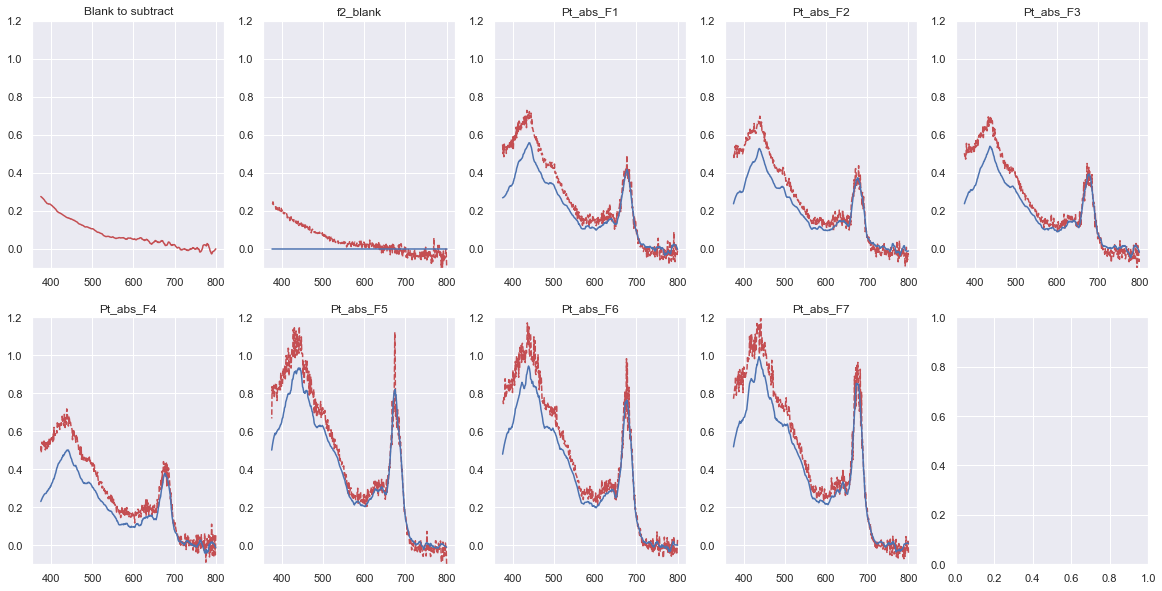

In [5]:
# Create blank subtracted versions of the samples
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
x = abs_raw['Wavelength (nm)'].values ## For plotting
# Get the f/2 reference blank- use the mean OD from 730 to 800
blank = abs_raw['f2_blank'].values
blank_filt = scipy.signal.savgol_filter(blank,17,2)
scatter = norm_mean['f2_blank']

#This is the blank to be subtracted from all samples
blank_sub = [(b-scatter) for b in blank_filt]
plt.subplot(2,5,1)
plt.plot(x,blank_sub,'r')
plt.title('Blank to subtract')
plt.ylim(-0.1,1.2)
# Subtract this blank from all the samples

abs_norm = abs_raw.copy()

samples = [i for i in abs_norm.keys() if i != 'Wavelength (nm)']
start = 2
for s in samples:
    # get values for the sample
    s_values = [float(val) for val in abs_norm[s].values]
    norm_values = scipy.signal.savgol_filter(s_values,17,2)
    
    # Subtract the reference blank from each value
    OD_norm = [(b-a) for b,a in zip(norm_values,blank_sub)]
    
    # And now subtract the OD750 from all values
    OD750 = norm_mean[s]
    
    OD750_norm = [(b-OD750) for b in OD_norm]
    
    # Update the DF with this value
    abs_norm[s]=OD750_norm
    
    plt.subplot(2,5,start)
    plt.plot(x,s_values,'r--')
    plt.plot(x,OD750_norm,'b')
    plt.title(s)
    plt.ylim(-0.1,1.2)
    start = start+1
  

### Correction for filter amplification
Equation 5 in Methods

Finkel Z V. & Irwin AJ (2001) Light absorption by phytoplankton and the filter amplification correction: cell size and species effects. J Exp Mar Biol Ecol 259: 51–61

In [9]:
## Convert from OD to absorbance and apply correction for filter amplification

def filt_corr(OD):
    OD_val = 2.303*(0.388*OD+(0.616*np.power(OD,2)))
    return OD_val

abs_corr = abs_norm[[c for c in abs_norm.columns if c != 'Wavelength (nm)']]
abs_corr = abs_corr.apply(filt_corr,axis=0)
abs_corr['Wavelength (nm)'] = abs_norm['Wavelength (nm)']


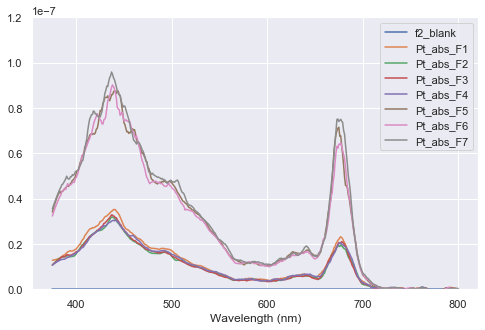

In [10]:
# Cell normalized absorption coefficient
## Cell densities (total cells, in millions)
abs_cell={'Pt_abs_F1' : 56.0,# High light acclimated
    'Pt_abs_F2' : 57.0, # High light acclimated 
    'Pt_abs_F3' : 57.2, # High light acclimated
    'Pt_abs_F4' : 55.4, # High light acclimated
    'Pt_abs_F5' : 49.5, # Low light acclimated
    'Pt_abs_F6' : 49.0, # Low light acclimated
    'Pt_abs_F7' : 50.0} # Low light acclimated

cell_norm = abs_corr.copy()

for col in cell_norm.columns:
    if col in abs_cell.keys():
        cell_count = abs_cell[col]*1e6
        cell_norm[col] = 2.1*cell_norm[col]/cell_count ## 2.1 is the surface area of the cells in cm2
        
cell_norm.plot(x='Wavelength (nm)', figsize = [8,5], ylim = [0,1.2e-7])

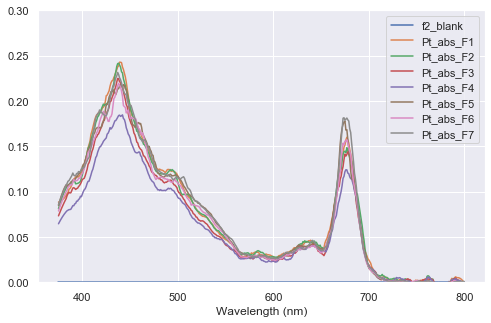

In [11]:
# Pigment normalized absorption coefficient
## Cell densities (total cells, in millions)
chl_cell={'Pt_abs_F1' : 1.45e-7,# High light acclimated
    'Pt_abs_F2' : 1.32e-7, # High light acclimated 
    'Pt_abs_F3' : 1.46e-7, # High light acclimated
    'Pt_abs_F4' : 1.65e-7, # High light acclimated
    'Pt_abs_F5' : 4.02e-7, # Low light acclimated
    'Pt_abs_F6' : 4.11e-7, # Low light acclimated
    'Pt_abs_F7' : 4.14e-7} # Low light acclimated

chl_norm = cell_norm.copy()

for col in chl_norm.columns:
    if col in chl_cell.keys():
        chl = chl_cell[col]
        chl_norm[col] = chl_norm[col]/chl ## chl is ug/cell

chl_norm.plot(x='Wavelength (nm)', figsize = [8,5], ylim = [0,0.3])

## Simultaneous oxygen evolution and PAM fluorimetry

In [12]:
### The LED output was measured to connect set points with actual photon fluxes.
PAR_val = pd.read_csv('2_Light_to_intensity.csv')

In [99]:
## For oxygen evolution, one HL acclimated flask was selected for demonstration. The files are 
### the raw outputs from the FireSting O2 sensor
import os
## Read in the raw O2 data and extract the relevant fields into a DataFrame
HL_files = ['2_Pt_Flask1_LC.txt', '2_Pt_Flask1_resp.txt']

HL_O2 = pd.DataFrame()

for i in range(len(HL_files)):
    item = HL_files[i]
    sample_id = item.split('.')[0]
    O2_data = pd.read_csv(item, sep='\t', skiprows=13, usecols=[2,4])
    temp_DF = O2_data[['Time (s)','Ch1']]
    temp_DF.columns = ['Time (s) '+sample_id,'O2 '+sample_id]
    if i == 0:
        HL_O2 = temp_DF.copy()
    else:
        HL_O2['Time (s) '+sample_id]= temp_DF[['Time (s) '+sample_id]]
        HL_O2['O2 '+sample_id]= temp_DF[['O2 '+sample_id]]    

In [104]:
## Read in the PAM data as it has the light intensity values and time points

Pt_PAM_all = pd.read_excel('2_PAM_all.xlsx')
LC_start = Pt_PAM_all.index[Pt_PAM_all['Action']=='LC-Start'].tolist()
LC_end = Pt_PAM_all.index[Pt_PAM_all['Action']=='LC-Stop'].tolist()

LC_order = ['Pt_Flask4_LC',
           'Pt_Flask1_LC',
           'Pt_Flask2_LC',
           'Pt_Flask3_LC',
           'Pt_Flask5_LC_2',
           'Pt_Flask6_LC',
           'Pt_Flask7_LC',
           'Pt_Flask5_LC',
           'Pt_Flask6_LC_2',
           'Pt_Flask4_LC_2']

data_org = dict(zip(LC_order,zip(LC_start,LC_end)))

In [106]:
## The PAM data is aggregated, this function allows for selection of a single sample

def get_PAM_data(sample_ID,PAM_DF, sample_to_LC):
    # Use the sample ID to get the range of rows for the desired data
    table_rows = range(sample_to_LC[sample_ID][0],sample_to_LC[sample_ID][1]+1)
    all_rows = PAM_DF.index.tolist()
    to_drop = [rows for rows in all_rows if rows not in table_rows]
    pared_DF = PAM_DF.drop(PAM_DF.index[to_drop])
    return pared_DF

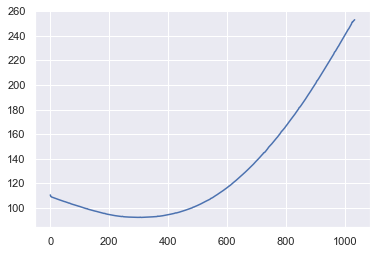

In [111]:
## This is how the raw data looks
o2_DF = HL_O2.copy()
sample = '2_Pt_Flask1_LC'
time = o2_DF['Time (s) '+sample].values.tolist()
o2_conc = o2_DF['O2 '+sample].values.tolist()

## There was a 5 second delay between intensity change and a resulting change in the O2 curve
off_set = 5 # seconds, valid for all the flasks
plt.plot(time,o2_conc)

In [184]:
## Take a linear regression between intensity changes
### Output is O2 in umol/(L*s)
import scipy
o2_samples = ['O2 2_Pt_Flask1_LC'] 
o2_out = pd.DataFrame(columns=o2_samples)
for s in o2_samples:
    o2_values = o2_DF[s].values.tolist()
    temp_list = list()
    if 'LC' in s:
        # 18 time points yeilding 17 datapoints
        for t in range(0,17):
            t_range = range((t*60+10+off_set),(((t+1)*60-10+off_set)))
            o2_temp = o2_values[min(t_range):(max(t_range)+1)]
            temp_list.append(scipy.stats.linregress(t_range,o2_temp).slope)

    try:
        o2_out[s]=temp_list

    except ValueError:
        delta = len(o2_out.index)-len(temp_list)
        for q in range(delta):
            temp_list.append('')
        o2_out[s]=temp_list

## Units are in umol/(L*s)
### Convert to umol/(cell*s)
## Total cells for O2 and PAM in millions
Pt_O2_F1 = 19.7
o2_out = o2_out/(Pt_O2_F1*1e6)/1000. 


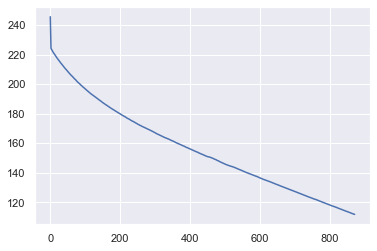

In [174]:
## Respiration
resp_DF = HL_O2.copy()
sample = '2_Pt_Flask1_resp'
time = o2_DF['Time (s) '+sample].values.tolist()
o2_conc = o2_DF['O2 '+sample].values.tolist()

## There was a 5 second delay between intensity change and a resulting change in the O2 curve
off_set = 5 # seconds, valid for all the flasks
plt.plot(time,o2_conc)

In [194]:
## Take a linear regression of 300-600 seconds
t_range = range(300,600,1)
o2_temp = o2_conc[min(t_range):(max(t_range)+1)]
resp = scipy.stats.linregress(t_range,o2_temp).slope/(Pt_O2_F1*1e6)/1000.
o2_all = [resp]+o2_out['O2 2_Pt_Flask1_LC'].values.tolist()

In [149]:
## PAM Data
HL_PAM_raw = get_PAM_data('Pt_Flask1_LC',Pt_PAM_all,data_org)
HL_PAR = [v for v in HL_PAM_raw['PAR'].values if not np.isnan(v)]

## Get 1-qL, Y(II), Y(NO), Y(NPQ)
HL_PAM = HL_PAM_raw[['Y(II)','Y(NO)','Y(NPQ)','qL']]
HL_PAM = HL_PAM.dropna(how='all')
HL_PAM = HL_PAM.reset_index(drop=True)


In [158]:
## Convert PAR set point to actually measured photon flux
measured = [0]
for par in HL_PAR[1:]:
    measured.append(PAR_val[PAR_val['PAM']==par]['Measured'].values[0])
    

In [195]:
# Create a HL Data Summary
HL_Data = HL_PAM[['Y(II)','Y(NO)','Y(NPQ)']]
HL_Data['1-qL'] = [(1-q) for q in HL_PAM['qL'].values]
HL_Data['O2']=o2_all
HL_Data['PAR']=measured

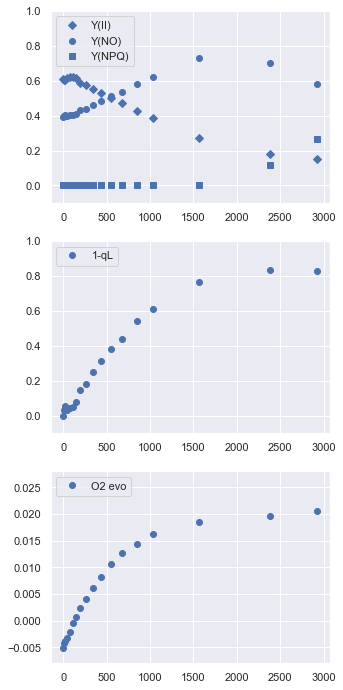

In [230]:
x = HL_Data['PAR'].values.tolist()
y1 = HL_Data['Y(II)'].values.tolist()
y2 = HL_Data['Y(NO)'].values.tolist()
y3 = HL_Data['Y(NPQ)'].values.tolist()

f = plt.figure(figsize=(5,12))
ax = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
ax.plot(x,y1,'bD', label = 'Y(II)')
ax.plot(x,y2,'bo', label = 'Y(NO)')
ax.plot(x,y3,'bs', label = 'Y(NPQ)')
ax.set_ylim(-0.1,1)
ax.legend()

ax2.plot(x,HL_Data['1-qL'].values.tolist(),'bo', label = '1-qL')
ax2.set_ylim(-0.1,1)
ax2.legend(loc =2)


ax3.plot(x,np.array(HL_Data['O2'].values.tolist())*1e9,'bo', label = 'O2 evo') # O2 converted to fmol/(cell*s)
ax3.set_ylim(-0.008,0.028)
ax3.legend(loc =2)

In [245]:
## Convert the irradiance from PAR to quantum flux and re-plot
## Load in the cell normalized absorbance spectrum
a_star = cell_norm[['Pt_abs_F1','Wavelength (nm)']]

## Load in the red LED specgtrum
irrad = pd.read_csv('2_PAM_LED.csv')

## Pare it down to only the area with photon flux to speed up the computation
a_star = a_star[a_star['Wavelength (nm)'] >= 592]
a_star = a_star[a_star['Wavelength (nm)'] <= 661]

In [261]:
## Cell density of the light curve
cell = 1.97E7 #cell/cm3 
PAR = HL_Data['PAR'].values.tolist()
### a* is in cm2/cell

QF = list()

# loop through wavelengths
r = 0.5
y_slices = 100
for p in PAR:
    Q_phar = 0.
    for w in a_star['Wavelength (nm)'].values:
        # Round cuvette option
        q_temp = 0.
        for y in range(y_slices):
            slice_temp = 0.
            y_val = y*(r/y_slices)
            l = 2*(m.pow((m.pow(r,2))-m.pow(y_val,2),0.5)) #full pathlength since it is based on radius
            ab_coef = (a_star[a_star['Wavelength (nm)']==w].Pt_abs_F1.values[0]) #abs in cm2/cell
            Io = (p*irrad[irrad.wavelength==w].rel_height.values[0])*(1.1*r/y_slices/1e4) #SA of the slice in cm2 then m2
            slice_temp =2*(Io - Io*(np.exp(-ab_coef*cell*l)))
            q_temp = q_temp+slice_temp
        Q_phar = Q_phar+q_temp
    QF.append((Q_phar/(cell)*1e9)) #fmol/cell*s

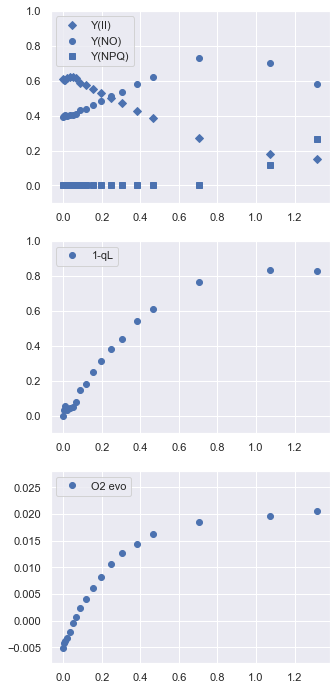

In [262]:
x = QF
y1 = HL_Data['Y(II)'].values.tolist()
y2 = HL_Data['Y(NO)'].values.tolist()
y3 = HL_Data['Y(NPQ)'].values.tolist()

f = plt.figure(figsize=(5,12))
ax = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
ax.plot(x,y1,'bD', label = 'Y(II)')
ax.plot(x,y2,'bo', label = 'Y(NO)')
ax.plot(x,y3,'bs', label = 'Y(NPQ)')
ax.set_ylim(-0.1,1)
ax.legend()

ax2.plot(x,HL_Data['1-qL'].values.tolist(),'bo', label = '1-qL')
ax2.set_ylim(-0.1,1)
ax2.legend(loc =2)


ax3.plot(x,np.array(HL_Data['O2'].values.tolist())*1e9,'bo', label = 'O2 evo') # O2 converted to fmol/(cell*s)
ax3.set_ylim(-0.008,0.028)
ax3.legend(loc =2)